In [172]:
import ast
import networkx as nx
import importlib
import utils
import style
import graph
importlib.reload(utils)
importlib.reload(style)
importlib.reload(graph)
from utils import ast_to_networkx, node_transform
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from graph import OurGraph
import xml.dom.minidom
from IPython.display import Image


In [166]:
my_file = 'test.py'
with open(my_file, 'r') as file:
    code = file.read()

tree = ast.parse(code)
# astor.to_source(tree)

# Print the AST
print(ast.dump(tree))

Module(body=[FunctionDef(name='main', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[FunctionDef(name='plus', args=arguments(posonlyargs=[], args=[arg(arg='a'), arg(arg='b')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Assign(targets=[Name(id='x', ctx=Store())], value=Name(id='a', ctx=Load())), Assign(targets=[Name(id='a', ctx=Store())], value=Constant(value=10)), Return(value=BinOp(left=Name(id='a', ctx=Load()), op=Add(), right=Name(id='b', ctx=Load())))], decorator_list=[])], decorator_list=[])], type_ignores=[])


In [167]:
G = ast_to_networkx(tree)

/var/folders/gl/5pxh7s9n19vfr9kxhf29vxyc0000gq/T/ipykernel_21592/3508742943.py:9: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


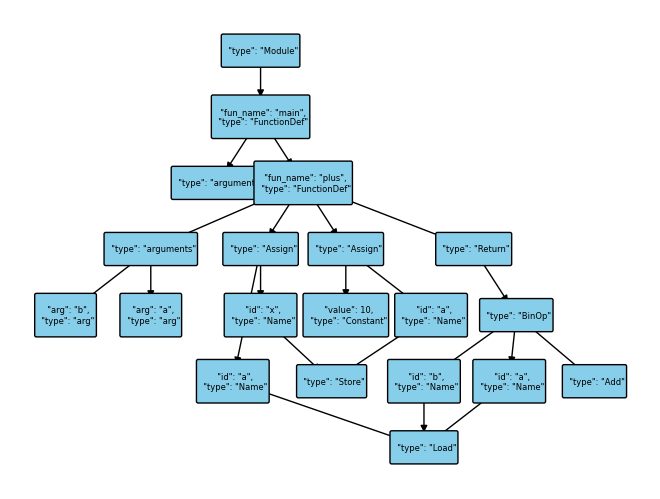

In [168]:
def visualize_ast(filename):
    with open(filename, 'r') as file:
        code = file.read()

    tree = ast.parse(code)
    G = ast_to_networkx(tree)

    node_labels = ({node: node_transform(G, node) for node in G.nodes()})
    pos = graphviz_layout(G, prog="dot")
    pos = {k: (x, 10*y) for k, (x, y) in pos.items()}
    node_size = [(len(node_transform(G, n))+20)*6 for n in G.nodes()]
    nx.draw(G, pos=pos, with_labels=True, node_size=node_size, labels=node_labels, node_shape="s", arrows = True, node_color="none", bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'), font_size=6)

    plt.show()
visualize_ast('test.py')

In [173]:
graph = OurGraph.from_file('test.py')

# Better visualization for AST

output.drawio -> output.png


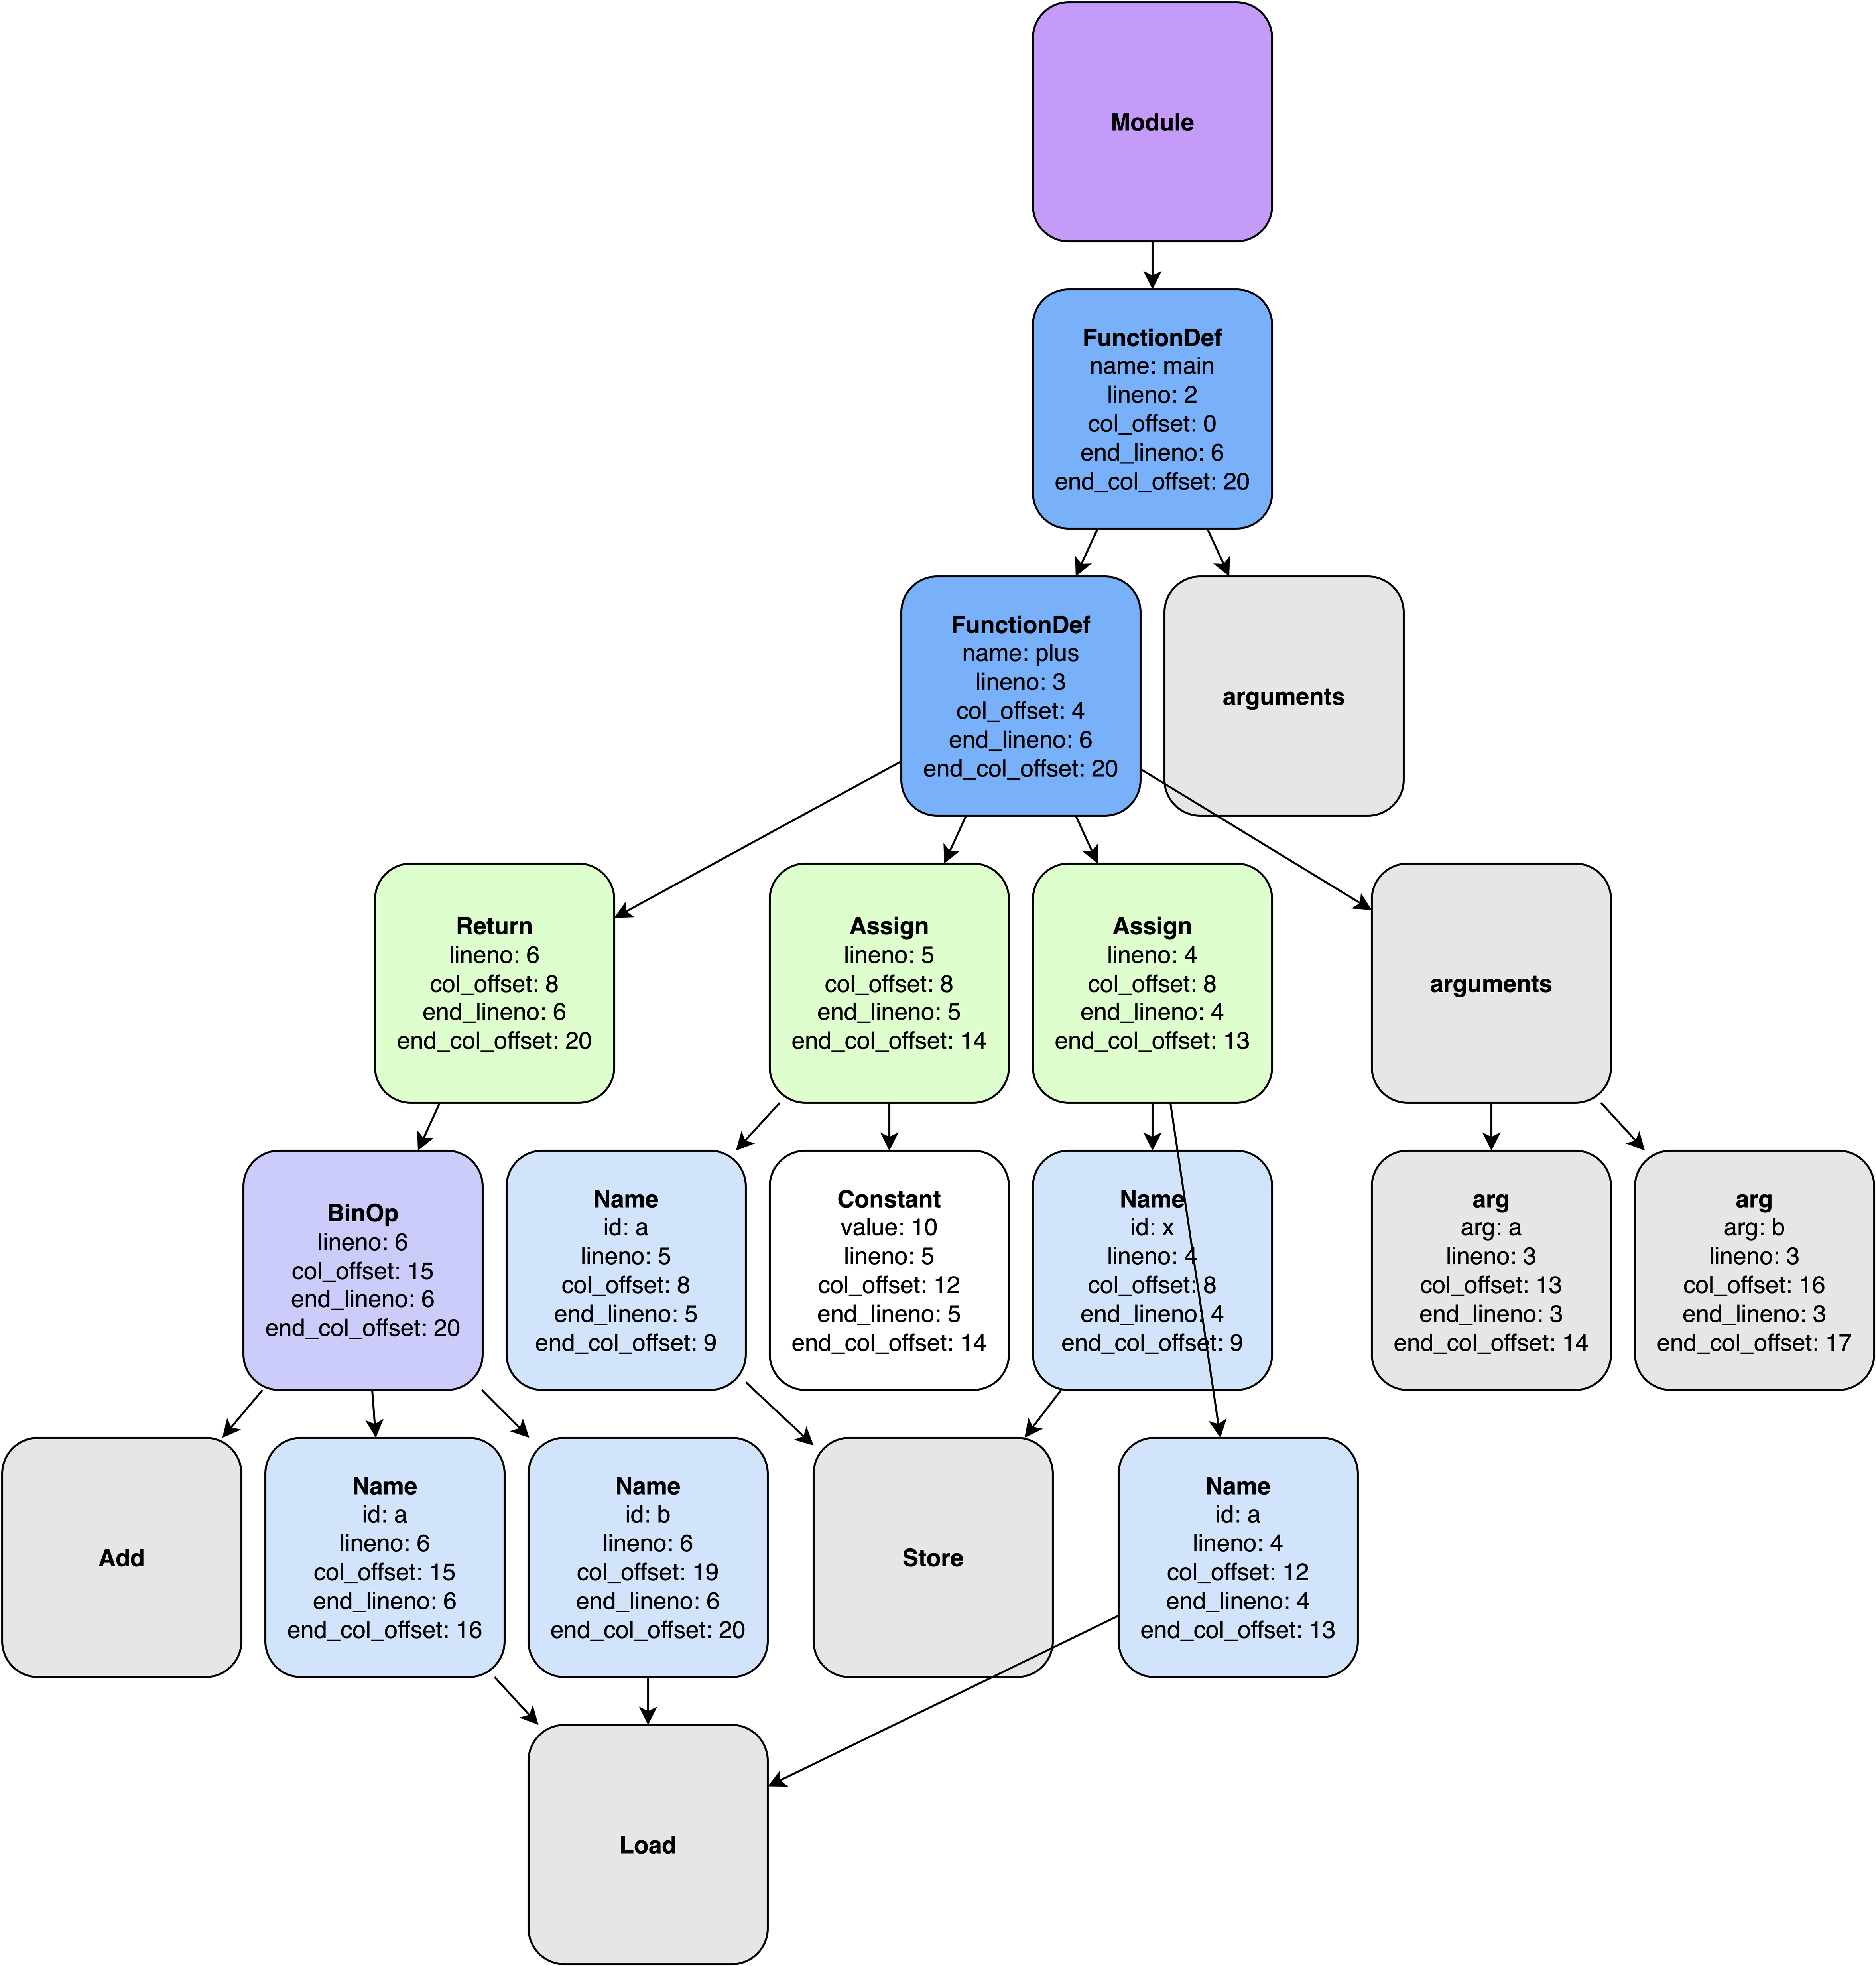

In [174]:
import graph
importlib.reload(style)
importlib.reload(graph)
from style import OurGraphToXML
import os 

graph_0 = OurGraph.from_file('test.py')
mxfile = OurGraphToXML(y_scaling=2).graph_to_xml(graph_0)
xml_str = xml.dom.minidom.parseString(ET.tostring(mxfile)).toprettyxml()
output_file = 'output.png'

filename = 'output.drawio'

with open(filename, 'w') as file:
    file.write(xml_str)
    
DRAWIO="/Applications/draw.io.app/Contents/MacOS/draw.io"

bashCommand = f"/Applications/draw.io.app/Contents/MacOS/draw.io -x -f png --scale 5   -o {output_file} {filename}"
os.system(bashCommand) 

Image(output_file)     
# print(xml_str)


In [ ]:
bin_op_node = [v for k, v in graph_0.our_nodes.items() if v.ast_node.__class__.__name__ == 'BinOp'][0]
bin_op_node.ast_node.__dict__

{'left': <ast.Name at 0x14c4baa40>,
 'op': <ast.Add at 0x100ea05b0>,
 'right': <ast.Name at 0x14c4bbfd0>,
 'lineno': 6,
 'col_offset': 15,
 'end_lineno': 6,
 'end_col_offset': 20}

In [ ]:
import copy 
# function expansion 
def expand_function(G: OurGraph, node_id):
    G = copy.deepcopy(G)
    node = G.ast_nodes[node_id]
    assert isinstance(node, ast.Call), f"Node {node} is not a function call"

    parent_id = G.get_parent(node_id)
    parent = G.ast_nodes[parent_id]
    # return parent
    assert parent.value == node, f"Parent node {parent} is not the function call {node}"

    function_defs = [
        n for n in G.ast_nodes.values() if isinstance(n, ast.FunctionDef) and n.name == node.func.id and n.lineno < node.lineno
    ]

    assert function_defs == 0, f"No function definition found for {node.func.id}"

    if function_defs > 1:
        print(f"Warning: Multiple function definitions for {node.func.id}")

    function_node = function_defs[-1]

    parent.value = copy.copy(function_node)
    G2 = OurGraph.from_ast(G.ast_tree)
    return G2


    

In [ ]:
for node_id, node  in graph.ast_nodes.items():
    if isinstance(node, ast.Call):
        # expand_function(graph, node.id)
        break

assign_nodes = [n for n in graph.ast_nodes.values() if isinstance(n, ast.Assign)]
expr_nodes = [n for n in graph.ast_nodes.values() if isinstance(n, ast.Expr)]
print(node_id, node.__dict__)

5320584128 {'func': <ast.Name object at 0x13d21ac50>, 'args': [<ast.Name object at 0x13d21ac80>, <ast.Name object at 0x13d21acb0>], 'keywords': [], 'lineno': 7, 'col_offset': 10, 'end_lineno': 7, 'end_col_offset': 20}


In [ ]:
parent = expand_function(graph, node_id)
# node.func.id

AssertionError: No function definition found for plus

In [ ]:
node_fun_def = [n for n in graph.ast_nodes.values() if isinstance(n, ast.FunctionDef)][1]

In [ ]:
node_fun_def.name

'plus'

In [ ]:
node_fun_def_copy = copy.deepcopy(node_fun_def)
node_fun_def_copy.__dict__

{'name': 'plus',
 'args': <ast.arguments at 0x14c0cc760>,
 'body': [<ast.Return at 0x14c0cd120>],
 'decorator_list': [],
 'returns': None,
 'type_comment': None,
 'lineno': 3,
 'col_offset': 4,
 'end_lineno': 4,
 'end_col_offset': 20}

In [ ]:
def substitute(node_fun_def: ast.FunctionDef, vars):
    rename = {arg.arg: var for arg, var in zip(node_fun_def.args.args, vars)}
    first_reload = None

    for node in ast.walk(node_fun_def):
        

    for node in ast.walk(node_fun_def):
        if isinstance(node, ast.Name):
            if node.id in rename:
                node.id = rename[node.id]
    return node_fun_def


In [ ]:
graph = OurGraph.from_file('test.py')
node_fun_def = [n for n in graph.ast_nodes.values() if isinstance(n, ast.FunctionDef)][1]
node_fun_def_copy = copy.deepcopy(node_fun_def)


output.drawio -> output.png


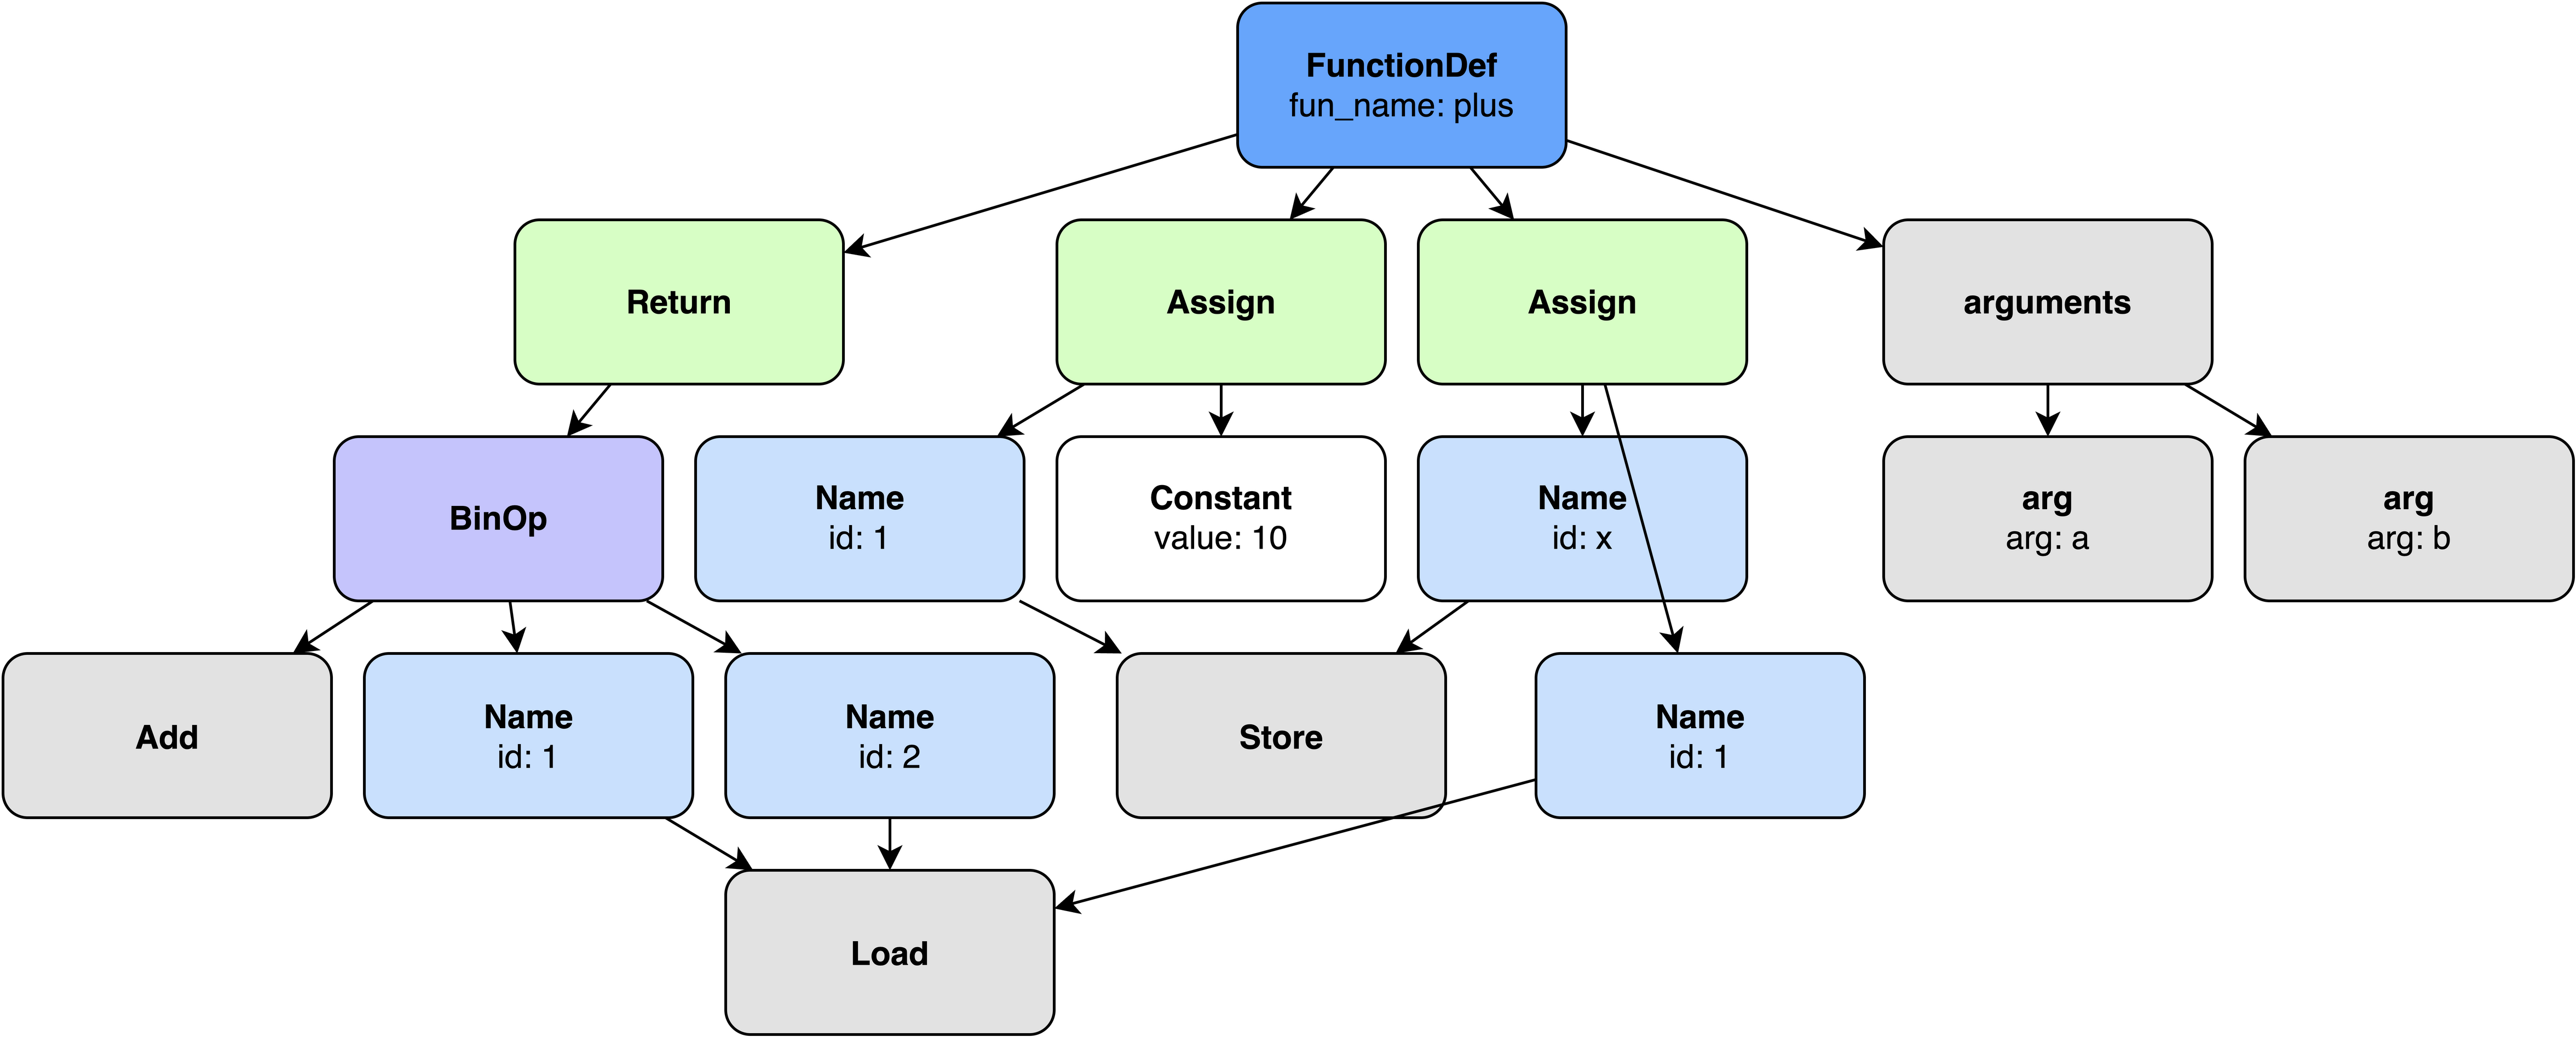

In [ ]:
graph = OurGraph(substitute(node_fun_def_copy, [1, 2]))
mxfile = OurGraphToXML(y_scaling=1.1).graph_to_xml(graph)
xml_str = xml.dom.minidom.parseString(ET.tostring(mxfile)).toprettyxml()
output_file = 'output.png'

filename = 'output.drawio'

with open(filename, 'w') as file:
    file.write(xml_str)
    
DRAWIO="/Applications/draw.io.app/Contents/MacOS/draw.io"

bashCommand = f"/Applications/draw.io.app/Contents/MacOS/draw.io -x -f png --scale 5   -o {output_file} {filename}"
os.system(bashCommand) 

Image(output_file) 

output_fun_def.drawio -> output_fun_def.png


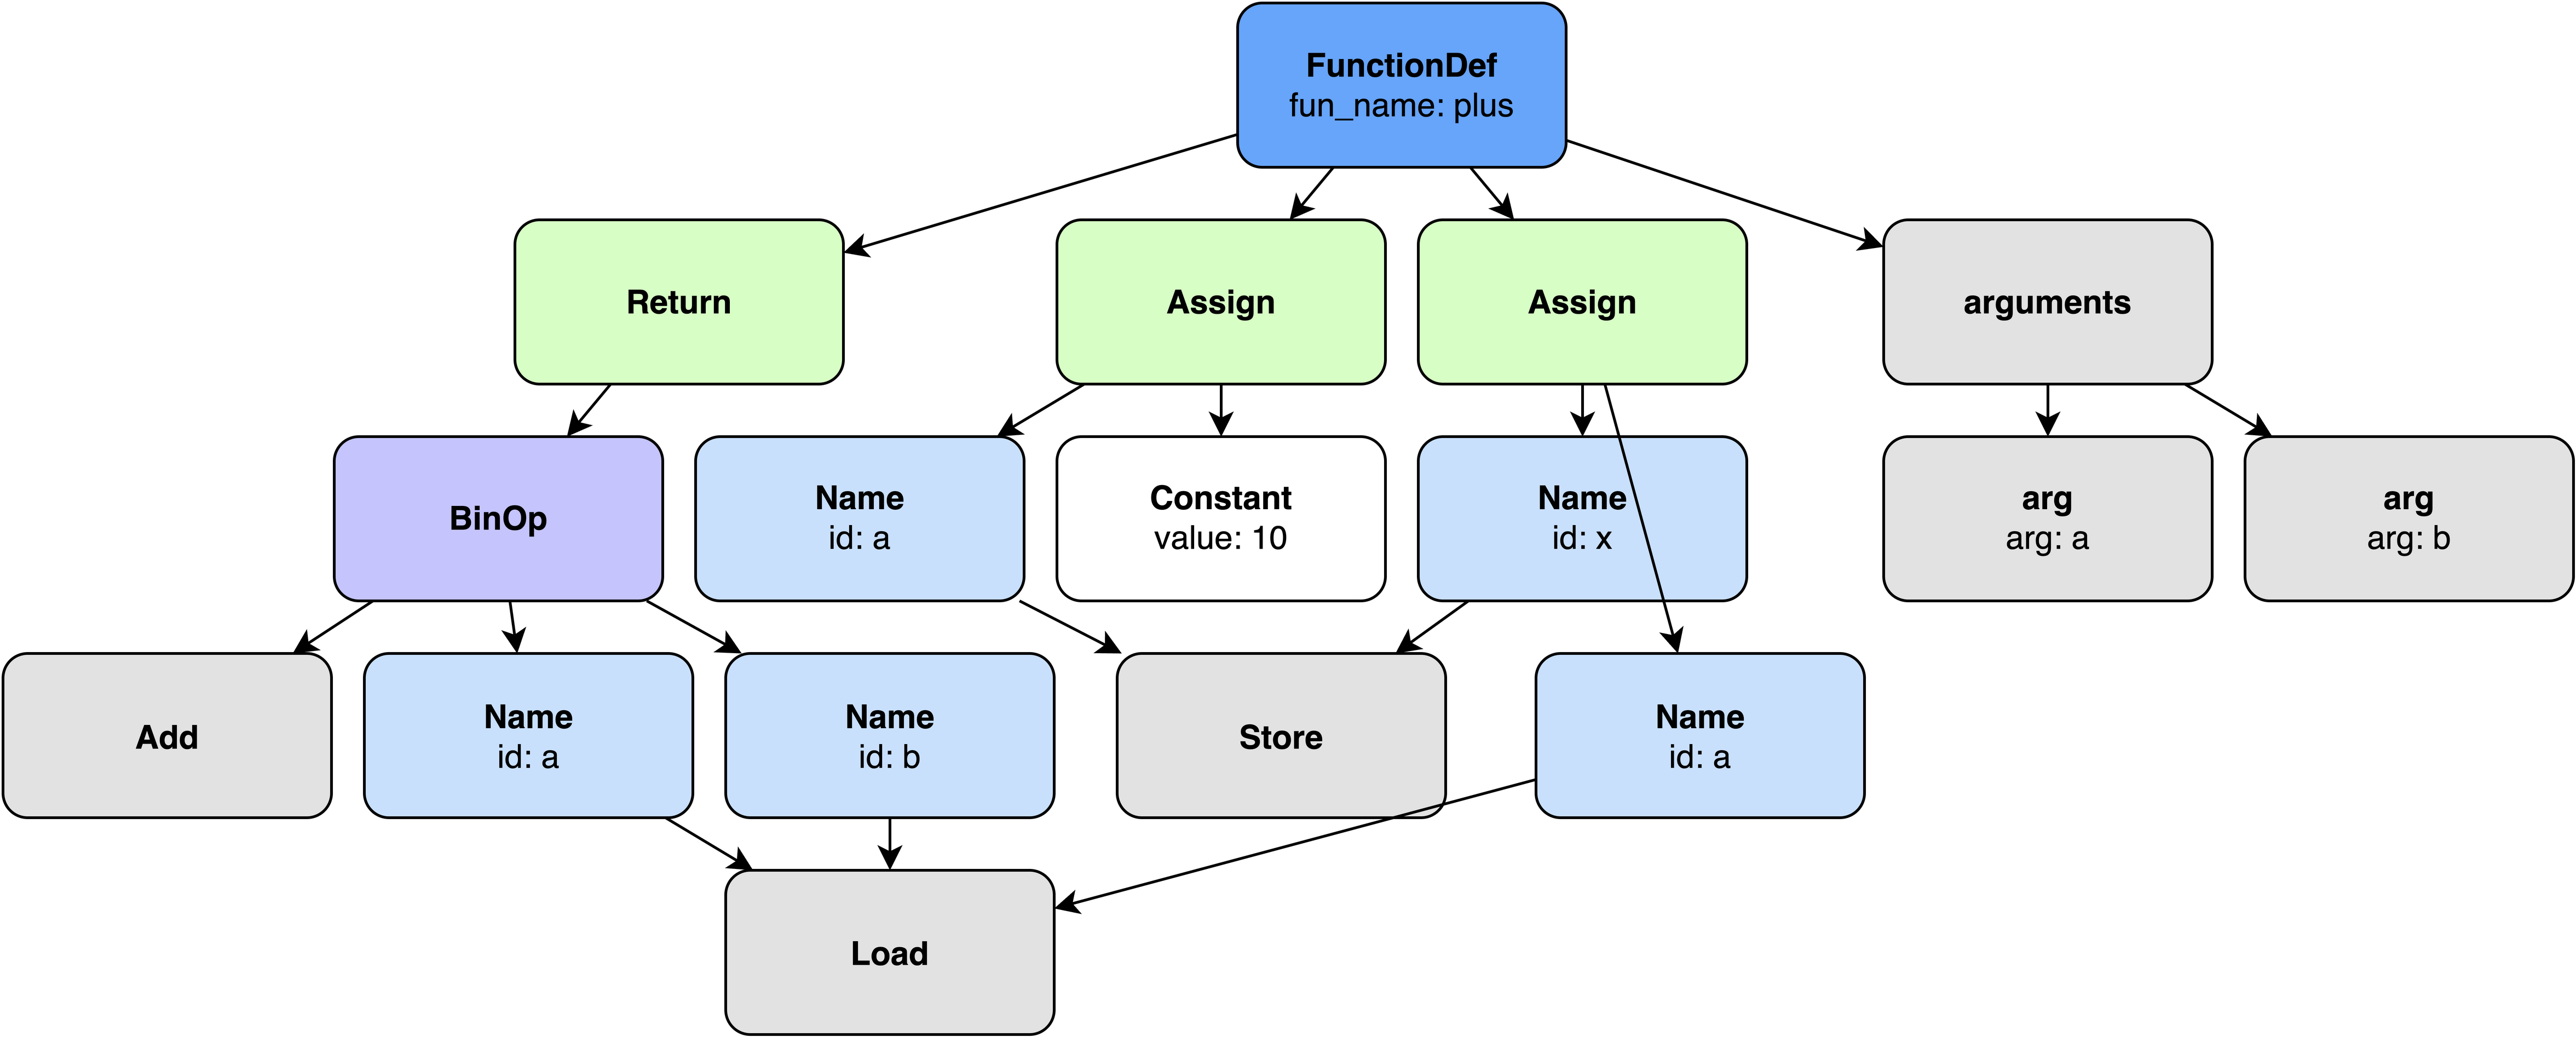

In [ ]:
graph = OurGraph(node_fun_def)
mxfile = OurGraphToXML(y_scaling=1.1).graph_to_xml(graph)
xml_str = xml.dom.minidom.parseString(ET.tostring(mxfile)).toprettyxml()
output_file = 'output_fun_def.png'

filename = 'output_fun_def.drawio'

with open(filename, 'w') as file:
    file.write(xml_str)
    
DRAWIO="/Applications/draw.io.app/Contents/MacOS/draw.io"

bashCommand = f"/Applications/draw.io.app/Contents/MacOS/draw.io -x -f png --scale 5   -o {output_file} {filename}"
os.system(bashCommand) 

Image(output_file) 

In [ ]:
assign_nodes = [n for n in graph.ast_nodes.values() if isinstance(n, ast.Assign)]
assign_nodes[0].targets[0].__dict__

{'id': 'x',
 'ctx': <ast.Store at 0x100ea03d0>,
 'lineno': 4,
 'col_offset': 8,
 'end_lineno': 4,
 'end_col_offset': 9}

In [ ]:
def plus(a, b):
    x = a
    a = 10
    return a + b

In [ ]:
node_fun_def.body[0].targets[0].__dict__

{'id': 'x',
 'ctx': <ast.Store at 0x100ea03d0>,
 'lineno': 4,
 'col_offset': 8,
 'end_lineno': 4,
 'end_col_offset': 9}